<a href="https://colab.research.google.com/github/zbasiri/clarku-assignment1/blob/master/Basiri_Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### **Section 1) Load of the Kaggle Cats vs Dogs dataset**



**- Download the 786M ZIP archive of the raw data**

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  67.3M      0  0:00:11  0:00:11 --:--:-- 70.7M


In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


- Now we have a PetImages folder which contain two subfolders (Cat and Dog) including image files for each category.

In [ ]:
!ls PetImages

Cat  Dog


### **Section 2) Coding of the convolutional neural network from scratch**

**- Filter out corrupted images** (Filter out badly-encoded images that do not feature the string "JFIF" in their header)

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


**- Generate Dataset** (Define data for training and validation)

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


**- Visualize the data**

first 9 images in the training dataset. Label 1 is "dog" and label 0 is "cat".

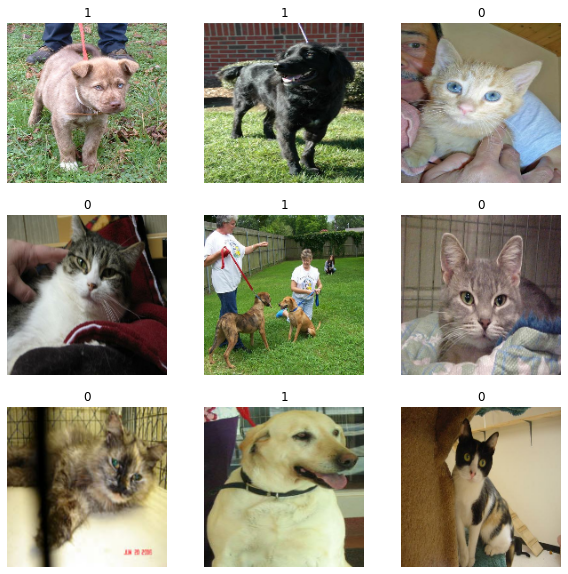

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**- Using image data augmentation**

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

**- Visualize augmented samples** (By applying data_augmentation repeatedly to the first image in the dataset)

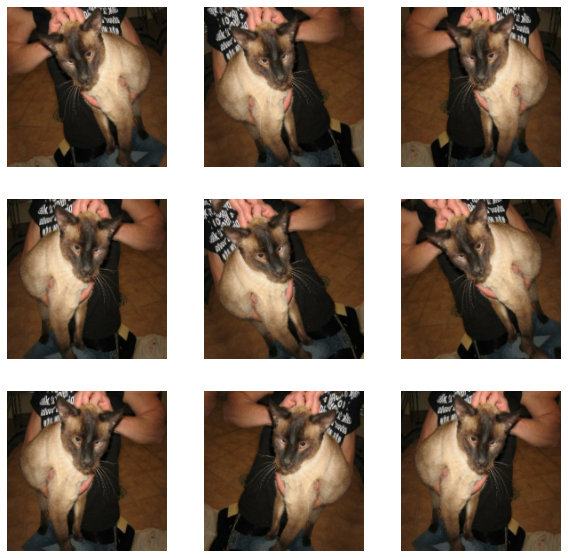

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Standardizing Data**

Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

**- Apply standardizing to the dataset**

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

**- Configure the dataset for performance**

Use buffered prefetching so we can yield data from disk without having I/O becoming blocking.

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

**- Build a model**

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture. We start the model with the data_augmentation preprocessor, followed by a Rescaling layer. We include a Dropout layer before the final classification layer.

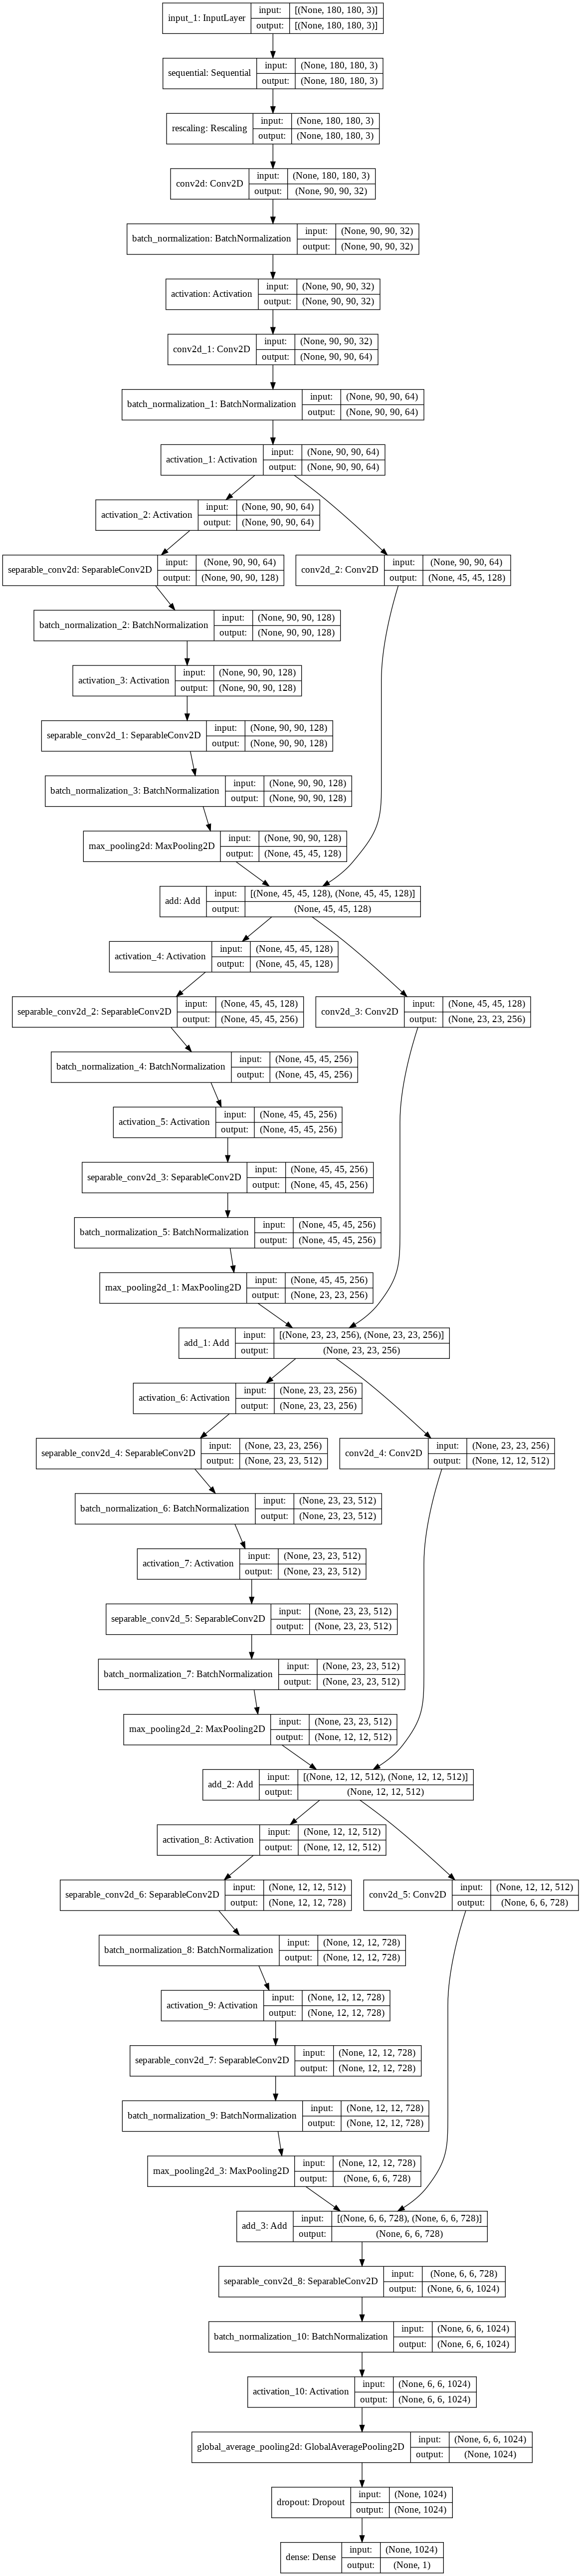

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


**- Train the model**

In [ ]:
import time
startTime = time.time()

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history=model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

endTime = time.time()

Epoch 1/5
586/586 [==============================] - 4500s 8s/step - loss: 0.5971 - accuracy: 0.6893 - val_loss: 0.7058 - val_accuracy: 0.5997


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
586/586 [==============================] - 4793s 8s/step - loss: 0.4420 - accuracy: 0.7951 - val_loss: 0.3697 - val_accuracy: 0.8398
Epoch 3/5
436/586 [=====================>........] - ETA: 18:38 - loss: 0.3600 - accuracy: 0.8422

In [ ]:
print(f'Training lasted : {endTime-startTime} seconds')

Training lasted : 8272.682653665543 seconds


**- Save the model**

In [ ]:
!pwd

/content


In [97]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [98]:
model.save('my_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
!ls saved_model

my_model


In [ ]:
!ls saved_model/my_model

assets	keras_metadata.pb  saved_model.pb  variables


In [ ]:
#import joblib

In [ ]:
#joblib.dump('saved_model/my_model','jb_my_model')

In [ ]:
#joblib.dump('saved_model/my_model','jb_my_model.pkl')

**- Test the model**

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 99.97 percent cat and 0.03 percent dog.


### **Section 3) Calculation of the accuracy of the model with 25 epochs and then 50 epochs**

In [ ]:
#Accuracy in epoch 50
accur_ep50 =history.history['accuracy'][-1]
print(accur_ep50)

0.9807774424552917


In [ ]:
#Accuracy in epoch 25
accur_ep25 =history.history['accuracy'][24]
print(accur_ep25)

0.9689769148826599


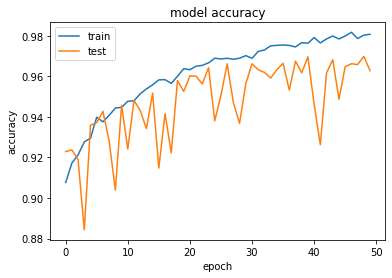

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **Section 4) Code an option that prompts the user for an image online** 

**- Read the image**

In [ ]:
from IPython import display

In [81]:
URL= input('Please Enter the URL of your image.')

Please Enter the URL of your image.https://hips.hearstapps.com/ghk.h-cdn.co/assets/16/08/gettyimages-464163411.jpg?crop=1.0xw:1xh;center,top&resize=980:*


   
 -> Your selected URL is: https://hips.hearstapps.com/ghk.h-cdn.co/assets/16/08/gettyimages-464163411.jpg?crop=1.0xw:1xh;center,top&resize=980:* and your selected image is:



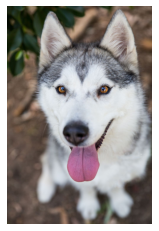

In [94]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

response = requests.get(URL, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
plt.axis('off')
print (f'   \n -> Your selected URL is: {URL} and your selected image is:\n')
plt.show()

**- Save the selected image in local path**

In [95]:
r = requests.get(URL)
with open('selected_image.jpg', 'wb') as outfile:
    outfile.write(r.content)

### **Section 5) Run your predictor model and provide the best classification of whether the image is a dog or a cat.**

In [96]:
test_image = keras.preprocessing.image.load_img("selected_image.jpg", target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(test_image)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score))

This image is 7.08 percent cat and 92.92 percent dog.
